# Objetivo:
Aplicar el metodo de Monte-Carlo a la integral de camino de un oscilador armonico simple cuantico


# Problema
Sea la integral de camino para el oscilador armonico:


$S[x(\tau)] = \int_{\tau_a}^{\tau_b} d\tau \left( -\frac{1}{2}m\dot{x}^2 + \frac{1}{2}m\omega^2 x^2 \right)$

Siendo $\tau$ el tiempo imaginario habiendo aplicado la rotacion de Wick $t \rightarrow i\tau$

In [45]:
# Librerias
import numpy as np
import matplotlib.pyplot as plt

In [46]:
# Constantes
N = 1000
we = 0.25            # Número de puntos del vector
k = (1/4)*we**2   # Parámetro del modelo
h = 1.0             # cte de Planck
delta = 1.5         # Rango
sweeps = 100    # Sweeps
sweeps_mc = 30

Encontramos de forma analitica la expresion para los cambios en la accion:

$\delta S/\hbar=\delta(\delta +2u_j − g(u_{j−1}+ u_{j+1}))$

In [47]:
def metropolis_rand(u, k, h, delta):
    g = (1 - k) / (1 + k)
    aceptados = 0
    N = u.shape[0]
    rng = np.random.default_rng()

    for _ in range(N):
        j = rng.integers(0, N)
        d = rng.uniform(-delta, delta)
        u_nuevo = u[j] + d

        # Para un campo 1D, los vecinos de j son (j-1) y (j+1).
        # Se usan condiciones de contorno periódicas para manejar los bordes.
        j_prev = (j - 1 + N) % N
        j_next = (j + 1) % N

        # El cálculo del cambio en la acción (ΔS)
        deltaS = d * (d + 2 * u[j] - g * (u[j_prev] + u[j_next]))

        # Condición de aceptación de Metropolis
        if deltaS < 0 or np.random.rand() < np.exp(-deltaS / h):
            u[j] = u_nuevo
            aceptados += 1

    return u, aceptados / N

In [48]:
def metropolis_seq(u, k, h, delta):
    g = (1 - k) / (1 + k)
    aceptados = 0
    N = u.shape[0]
    rng = np.random.default_rng()

    for j in range(N):
        d = rng.uniform(-delta, delta)
        u_nuevo = u[j] + d

        # Para un campo 1D, los vecinos de j son (j-1) y (j+1).
        # Se usan condiciones de contorno periódicas para manejar los bordes.
        j_prev = (j - 1 + N) % N
        j_next = (j + 1) % N

        # El cálculo del cambio en la acción (ΔS)
        deltaS = d * (d + 2 * u[j] - g * (u[j_prev] + u[j_next]))

        # Condición de aceptación de Metropolis
        if deltaS < 0 or np.random.rand() < np.exp(-deltaS / h):
            u[j] = u_nuevo
            aceptados += 1

    return u, aceptados / N

In [49]:
''' ------------ Random ------------ '''

# Inicialización de u (cold start)
u = np.zeros(N)

# Listas para guardar datos
pasos = []
configs_rand = []
tasas_aceptacion = []

for _ in range(sweeps_mc):

  # Simulación
  for n in range(sweeps):
    # Paso de Metropolis
    u,aceptacion = metropolis_rand(u,k,h,delta)

    # Guardamos
    tasas_aceptacion.append(aceptacion)
    configs_rand.append(np.copy(u))

''' ------------ Sequencial ------------ '''

# Inicialización de u (cold start)
u = np.zeros(N)

# Listas para guardar datos
pasos = []
configs_seq = []
tasas_aceptacion = []

for _ in range(sweeps_mc):

  # Simulación
  for n in range(sweeps):
    # Paso de Metropolis
    u,aceptacion = metropolis_seq(u,k,h,delta)

    # Guardamos
    pasos.append(n)
    tasas_aceptacion.append(aceptacion)
    configs_seq.append(np.copy(u))


## Graficos

In [50]:
# Graficar
# plt.plot(pasos[100:], u[100:], 'c-', lw=1)
# plt.title("Trayectoria")

# plt.ylim(-8,8)
# plt.tight_layout()
# plt.grid()
# plt.ylabel("")
# plt.xlabel("Sweeps")
# plt.savefig("Trayectorias.png",dpi=400, bbox_inches='tight')
# plt.show()

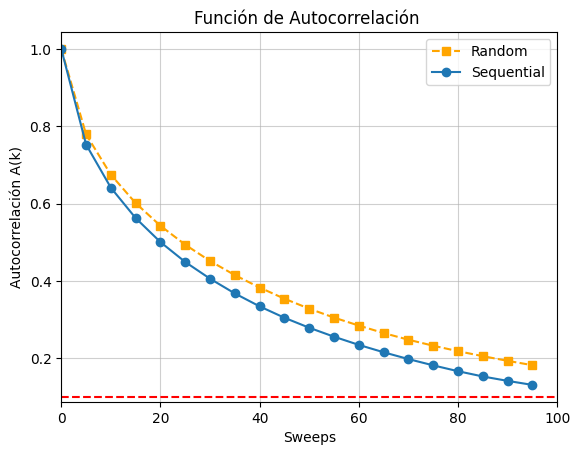

In [51]:
# configs es nuestro array de N mediciones
def autocorrelation(configs,desfase,t_max):
  N = len(configs)
  u_mean = np.mean(configs)
  u_var = np.var(configs)  # Esto es C(0)

  autocorrelation_function = []
  t_range = np.arange(0,t_max,desfase)

  for k in t_range:
      # Calcular A(k)
      # Tomar dos "rodajas" del array, separadas por t_0
      data_t = configs[0 : N-k]
      data_t_plus_k = configs[k : N]

      # Calcular el producto de las fluctuaciones
      covariance_k = np.mean( (data_t - u_mean) * (data_t_plus_k - u_mean) )

      # Normalizar por la varianza
      A_k = covariance_k / u_var
      autocorrelation_function.append(A_k)

  return autocorrelation_function

a = autocorrelation(configs_rand,5,100)
b = autocorrelation(configs_seq,5,100)


x = np.arange(0, 100,5)

plt.plot(x, a, marker='s',linestyle='--',color='orange',label=f'Random')
plt.plot(x, b, marker='o',linestyle='-', label=f'Sequential')
plt.axhline(0.1, color='red', linestyle='--')
plt.xlabel("Sweeps")
plt.ylabel("Autocorrelación A(k)")
plt.title("Función de Autocorrelación ")
plt.xlim(0,100)
plt.legend()
plt.grid(True, alpha=0.6)

plt.savefig("Rand_Vs_Seq", dpi=400, bbox_inches='tight')

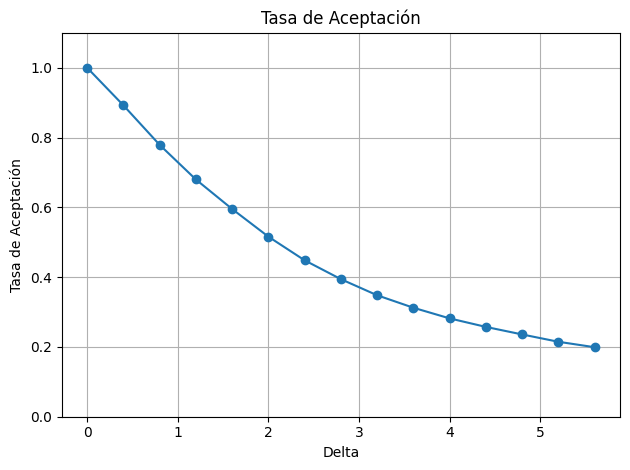

In [55]:
delta_range = np.arange(0,6,0.4)
tasas_aceptacion = []
u = np.zeros(N)

# Simulacion
for delta in delta_range:
    aceptaciones = []
    for _ in range(100):
        u, aceptacion = metropolis_rand(u, k, h, delta)
        aceptaciones.append(aceptacion)

    tasa_promedio = np.mean(aceptaciones)
    tasas_aceptacion.append(tasa_promedio)

# Grafico
plt.plot(delta_range, tasas_aceptacion, marker='o')
plt.xlabel("Delta")
plt.ylabel("Tasa de Aceptación")
plt.title("Tasa de Aceptación")
plt.ylim(0,1.1)
plt.tight_layout()
plt.grid()
plt.savefig("Aceptacion_Vs_Delta",dpi=400, bbox_inches='tight')
plt.show()